In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [2]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [3]:
schema_ratings = StructType([
    StructField("user_id", IntegerType(), False),
    StructField("item_id", IntegerType(), False),
    StructField("rating", IntegerType(), False),
    StructField("timestamp", IntegerType(), False)])

schema_items = StructType([
    StructField("item_id", IntegerType(), False),
    StructField("movie", StringType(), False)])

training = spark.read.option("sep", "\t").csv("../MovieLens.training", header=False, schema=schema_ratings)
test = spark.read.option("sep", "\t").csv("MovieLens.test", header=False, schema=schema_ratings)
items = spark.read.option("sep", "|").csv("MovieLens.item", header=False, schema=schema_items)

# Base Model

In [4]:
# 0.1
als = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.9276668815819209

# Data Injection

In [5]:
movie = training.toPandas()
movie

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [6]:
movie.rating.describe()

count    80000.000000
mean         3.528350
std          1.118565
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [7]:
ratings = movie.rating.to_numpy()
ratings

array([5, 3, 4, ..., 3, 3, 3], dtype=int32)

### Original Distribution

(array([ 4719.,     0.,  9178.,     0.,     0., 21963.,     0., 27396.,
            0., 16744.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

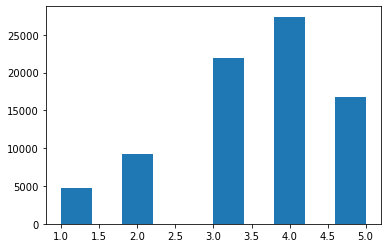

In [8]:
plt.hist(movie.rating)

(array([ 5778.,  4287.,  5607.,  7057., 10490., 10454.,  9415.,  8113.,
         8795., 10004.]),
 array([  1. ,  95.2, 189.4, 283.6, 377.8, 472. , 566.2, 660.4, 754.6,
        848.8, 943. ]),
 <BarContainer object of 10 artists>)

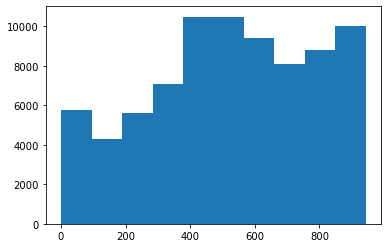

In [9]:
plt.hist(movie.user_id)

(array([18855., 22860., 11353.,  9279.,  7262.,  4428.,  3428.,  1500.,
          684.,   351.]),
 array([1.0000e+00, 1.6910e+02, 3.3720e+02, 5.0530e+02, 6.7340e+02,
        8.4150e+02, 1.0096e+03, 1.1777e+03, 1.3458e+03, 1.5139e+03,
        1.6820e+03]),
 <BarContainer object of 10 artists>)

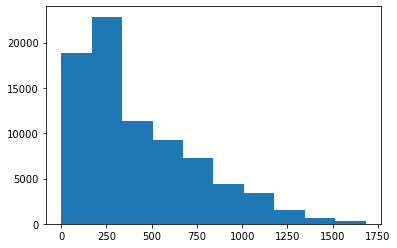

In [10]:
plt.hist(movie.item_id)

# Generate the random ratings from the global distribution

### 1000 Generated

In [30]:
random_ratings = movie['rating'].sample(n=1000, random_state=1).to_numpy()
#random_ratings

(array([ 65.,   0., 110.,   0.,   0., 282.,   0., 321.,   0., 222.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

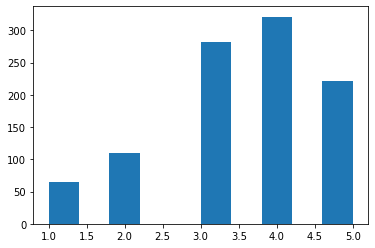

In [12]:
plt.hist(random_ratings)

In [31]:
random_users = movie['user_id'].sample(n=1000, random_state=1).to_numpy()
#random_users

(array([ 71.,  48.,  67.,  84., 135., 102., 138., 103., 124., 128.]),
 array([  1. ,  95.2, 189.4, 283.6, 377.8, 472. , 566.2, 660.4, 754.6,
        848.8, 943. ]),
 <BarContainer object of 10 artists>)

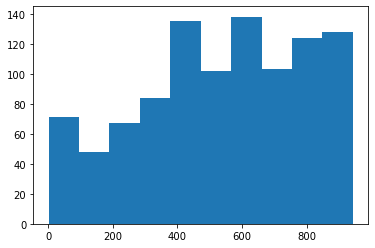

In [14]:
plt.hist(random_users)

In [32]:
random_movies = movie['item_id'].sample(n=1000, random_state=1).to_numpy()
#random_movies

(array([226., 267., 130., 123.,  85.,  52.,  67.,  31.,  12.,   7.]),
 array([1.0000e+00, 1.5490e+02, 3.0880e+02, 4.6270e+02, 6.1660e+02,
        7.7050e+02, 9.2440e+02, 1.0783e+03, 1.2322e+03, 1.3861e+03,
        1.5400e+03]),
 <BarContainer object of 10 artists>)

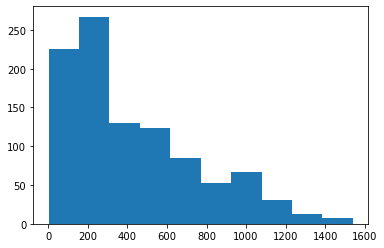

In [16]:
plt.hist(random_movies)

In [17]:
attack_1000 = pd.DataFrame({'user_id': random_users, 'item_id': random_movies, 'rating': random_ratings})
attack_1000

,user_id,item_id,rating
0,126,690,3
1,606,15,5
2,817,329,4
3,823,721,4
4,758,343,2
...,...,...,...
995,595,845,3
996,476,33,4
997,870,659,4
998,458,288,3


In [19]:
attack = pd.concat([movie, attack_1000]).sort_values(by=['user_id', 'item_id'])
attack

,user_id,item_id,rating,timestamp
0,1,1,5,874965758.0
1,1,2,3,876893171.0
2,1,3,4,878542960.0
3,1,4,3,876893119.0
4,1,5,3,889751712.0
...,...,...,...,...
79995,943,1067,2,875501756.0
79996,943,1074,4,888640250.0
79997,943,1188,3,888640250.0
79998,943,1228,3,888640275.0


In [28]:
attackedDF = spark.createDataFrame(attack)
attackedDF

DataFrame[user_id: bigint, item_id: bigint, rating: bigint, timestamp: double]

# Evaluate based on the random attack

In [29]:
# 0.1
als = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(attackedDF)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.9281964114729292

RMSE is basically the same..